**Social Networks and Recommendation Systems Project 12**

*Salveen Singh Dutt*

*Patryk Prusak*

In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast
from datetime import datetime
import seaborn as sns
from collections import Counter
from textblob import TextBlob

### Functions

In [32]:
# Created with a bit of help from GitHub Copilot


def categorize_sentiment(score):
    if score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"


def load_twitter_data(url):
    """
    Load Twitter data with proper parsing of list fields
    """
    try:
        df = pd.read_csv(url)
        # Convert string representations of lists to actual lists
        df["hashtags"] = df["hashtags"].apply(ast.literal_eval)
        df["mentions"] = df["mentions"].apply(ast.literal_eval)
        df["expanded_urls"] = df["expanded_urls"].apply(ast.literal_eval)
        print(f"Loaded {len(df)} tweets")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


def user_behavior_analysis(df):
    user_activity = df.groupby("user_id").size().sort_values(ascending=False)
    df["created_at"] = pd.to_datetime(df["created_at"], unit="ms")

    df["date"] = df["created_at"].dt.date
    df["hour"] = df["created_at"].dt.hour
    df["day_of_week"] = df["created_at"].dt.day_name()
    df["month"] = df["created_at"].dt.month
    df["year"] = df["created_at"].dt.year
    return user_activity


def content_analysis(df):
    hashtag_counts = Counter([tag for tags in df["hashtags"] for tag in tags])
    df["sentiment"] = (
        df["text"].fillna("").apply(lambda x: TextBlob(x).sentiment.polarity)
    )
    return hashtag_counts


def create_interaction_network(df):
    """
    Create a network based on mentions, retweets, and replies
    """
    G = nx.DiGraph()

    for _, row in df.iterrows():
        source_user = row["user_key"]

        # Add source user node
        if not G.has_node(source_user):
            G.add_node(source_user)

        # Add edges for mentions
        for mentioned_user in row["mentions"]:
            if not G.has_node(mentioned_user):
                G.add_node(mentioned_user)
            G.add_edge(source_user, mentioned_user, type="mention")

        # Add edges for replies
        if (
            pd.notna(row["in_reply_to_status_id"])
            and row["in_reply_to_status_id"] != ""
        ):
            reply_to = df[df["tweet_id"] == row["in_reply_to_status_id"]][
                "user_key"
            ].values
            if len(reply_to) > 0:
                if not G.has_node(reply_to[0]):
                    G.add_node(reply_to[0])
                G.add_edge(source_user, reply_to[0], type="reply")

        # Add edges for retweets
        if pd.notna(row["retweeted_status_id"]) and row["retweeted_status_id"] != "":
            retweeted = df[df["tweet_id"] == row["retweeted_status_id"]][
                "user_key"
            ].values
            if len(retweeted) > 0:
                if not G.has_node(retweeted[0]):
                    G.add_node(retweeted[0])
                G.add_edge(source_user, retweeted[0], type="retweet")

    return G


def analyze_network(G):
    """
    Perform network analysis and return key metrics
    """
    metrics = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
    }

    # Calculate various centrality metrics
    metrics["degree_cent"] = nx.degree_centrality(G)
    metrics["in_degree_cent"] = nx.in_degree_centrality(G)
    metrics["out_degree_cent"] = nx.out_degree_centrality(G)

    # Find top users by different metrics
    metrics["top_influential"] = sorted(
        metrics["degree_cent"].items(), key=lambda x: x[1], reverse=True
    )[:10]
    metrics["top_mentioned"] = sorted(
        metrics["in_degree_cent"].items(), key=lambda x: x[1], reverse=True
    )[:10]
    metrics["top_active"] = sorted(
        metrics["out_degree_cent"].items(), key=lambda x: x[1], reverse=True
    )[:10]

    return metrics


def visualize_network(G, metrics, title="Twitter Interaction Network"):
    """
    Create and save network visualization with different edge colors for different types
    """
    plt.figure(figsize=(15, 10))

    # Use spring layout for visualization
    pos = nx.spring_layout(G, k=1.5, iterations=50)

    # Draw nodes
    node_sizes = [3000 * metrics["degree_cent"][node] for node in G.nodes()]
    nx.draw_networkx_nodes(
        G, pos, node_color="lightblue", node_size=node_sizes, alpha=0.7
    )

    # Draw edges with different colors based on type
    edge_colors = {"mention": "blue", "reply": "green", "retweet": "red"}

    for edge_type, color in edge_colors.items():
        edges = [
            (u, v) for (u, v, d) in G.edges(data=True) if d.get("type") == edge_type
        ]
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=edges,
            edge_color=color,
            alpha=0.4,
            arrows=True,
            arrowsize=10,
        )

    # Add legend
    plt.plot([], [], "b-", label="Mention")
    plt.plot([], [], "g-", label="Reply")
    plt.plot([], [], "r-", label="Retweet")
    plt.legend()

    plt.title(title)
    plt.axis("off")
    plt.savefig("twitter_network.png", dpi=300, bbox_inches="tight")
    plt.close()


def analyze_tweet_patterns(df):
    """
    Analyze patterns in the tweet dataset
    """
    patterns = {
        "total_tweets": len(df),
        "unique_users": df["user_key"].nunique(),
        "hashtag_stats": {},
        "temporal_patterns": {},
    }

    # Analyze hashtags
    all_hashtags = [tag for tags in df["hashtags"] for tag in tags]
    patterns["hashtag_stats"] = {
        "total_hashtags": len(all_hashtags),
        "unique_hashtags": len(set(all_hashtags)),
        "top_hashtags": pd.Series(all_hashtags).value_counts().head(10).to_dict(),
    }

    # Temporal analysis
    df["created_at"] = pd.to_datetime(df["created_str"])
    patterns["temporal_patterns"] = {
        "tweets_by_hour": df.groupby(df["created_at"].dt.hour).size().to_dict(),
        "tweets_by_day": df.groupby(df["created_at"].dt.dayofweek).size().to_dict(),
    }

    return patterns


def generate_report(df, metrics, patterns):
    """
    Generate comprehensive analysis report
    """
    report = f"""
Twitter Network Analysis Report
=============================

Network Statistics:
-----------------
• Total Users in Network: {metrics['num_nodes']:,}
• Total Interactions: {metrics['num_edges']:,}
• Network Density: {metrics['density']:.4f}
• Average Interactions per User: {metrics['avg_degree']:.2f}

Top Influential Users (by Total Interactions):
------------------------------------------
"""
    for user, score in metrics["top_influential"]:
        report += f"• {user}: {score:.4f}\n"

    report += "\nMost Mentioned Users:\n"
    for user, score in metrics["top_mentioned"]:
        report += f"• {user}: {score:.4f}\n"

    report += "\nMost Active Users:\n"
    for user, score in metrics["top_active"]:
        report += f"• {user}: {score:.4f}\n"

    report += "\nHashtag Analysis:\n"
    report += (
        f"• Total Hashtags Used: {patterns['hashtag_stats']['total_hashtags']:,}\n"
    )
    report += f"• Unique Hashtags: {patterns['hashtag_stats']['unique_hashtags']:,}\n"
    report += "\nTop Hashtags:\n"
    for hashtag, count in patterns["hashtag_stats"]["top_hashtags"].items():
        report += f"• #{hashtag}: {count:,} uses\n"

    return report

In [33]:
url = "https://nodeassets.nbcnews.com/russian-twitter-trolls/tweets.csv"

df = load_twitter_data(url)

Loaded 203451 tweets


### User behaviour analysis

In [15]:
user_activity = user_behavior_analysis(df)

#### Most active users

In [16]:
user_activity.head(5)

user_id
1.679279e+09    9269
1.671235e+09    6813
2.882014e+09    6652
2.671070e+09    4140
4.508631e+09    3663
dtype: int64

#### Daily, Monthly etc. activity analysis

In [ ]:
daily_activity = df.groupby("date").size()

weekly_activity = df.resample("W", on="created_at").size()

monthly_activity = df.resample("M", on="created_at").size()

C:\Users\patrykprusak\AppData\Local\Temp\ipykernel_43144\2803615432.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_activity = df.resample('M', on='created_at').size()


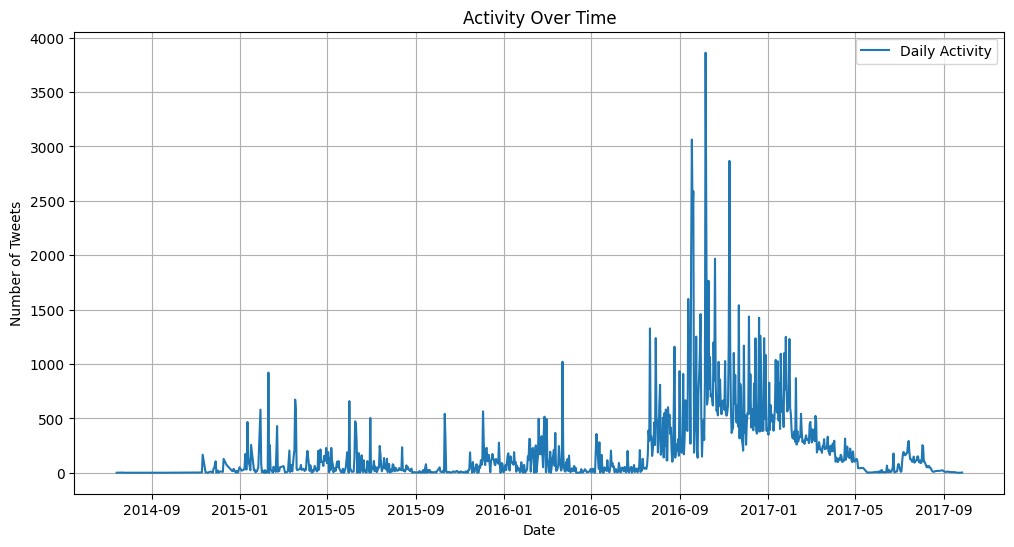

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(daily_activity.index, daily_activity.values, label="Daily Activity")
plt.title("Activity Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(True)
plt.show()

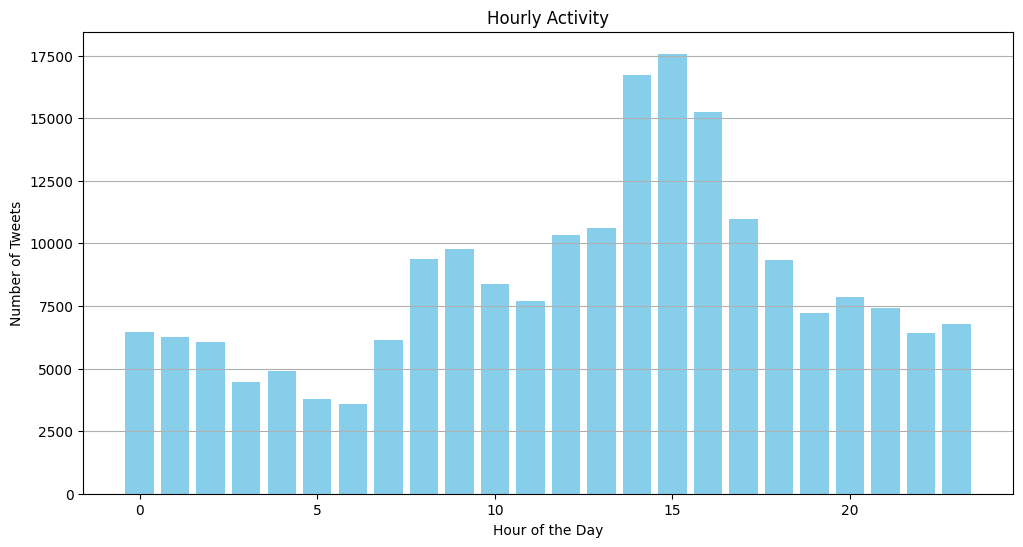

In [19]:
hourly_activity = df.groupby("hour").size()

plt.figure(figsize=(12, 6))
plt.bar(hourly_activity.index, hourly_activity.values, color="skyblue")
plt.title("Hourly Activity")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Tweets")
plt.grid(axis="y")
plt.show()

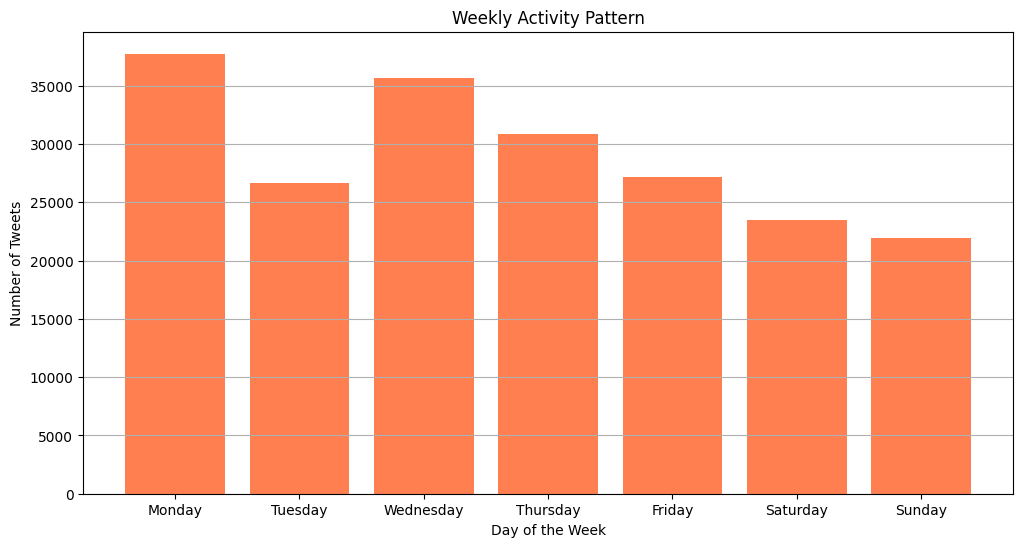

In [20]:
weekly_pattern = (
    df.groupby("day_of_week")
    .size()
    .reindex(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    )
)

plt.figure(figsize=(12, 6))
plt.bar(weekly_pattern.index, weekly_pattern.values, color="coral")
plt.title("Weekly Activity Pattern")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Tweets")
plt.grid(axis="y")
plt.show()

In [21]:
threshold = daily_activity.mean() + 3 * daily_activity.std()
anomalies = daily_activity[daily_activity > threshold]

print("Anomalies in activity:")
print(anomalies)

Anomalies in activity:
date
2016-07-21    1327
2016-09-12    1598
2016-09-16    1992
2016-09-17    3063
2016-09-18    2367
2016-09-19    2587
2016-09-29    1459
2016-10-06    3861
2016-10-07    2221
2016-10-10    1765
2016-10-19    1968
2016-11-08    2867
2016-11-21    1540
2016-12-05    1437
2016-12-19    1425
dtype: int64


### Content analysis

In [36]:
hashtag_counts = content_analysis(df)

#### Hashtags

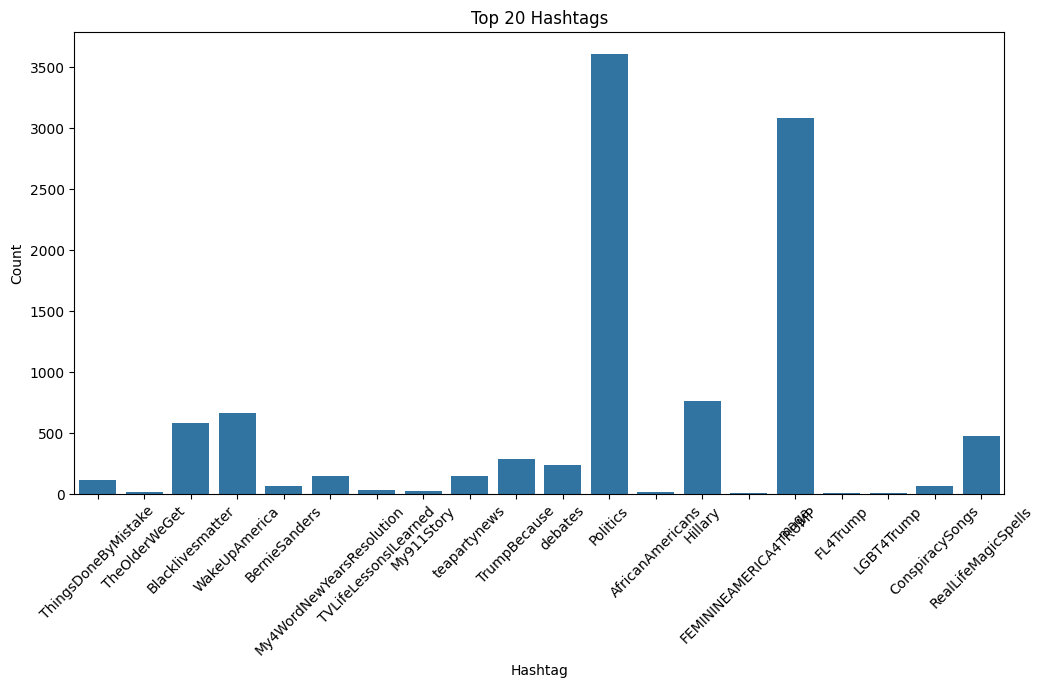

In [29]:
hashtags_df = pd.DataFrame(hashtag_counts.items(), columns=["hashtag", "count"])
plt.figure(figsize=(12, 6))
sns.barplot(x="hashtag", y="count", data=hashtags_df.head(20))
plt.title("Top 20 Hashtags")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

#### Sentiment analysis

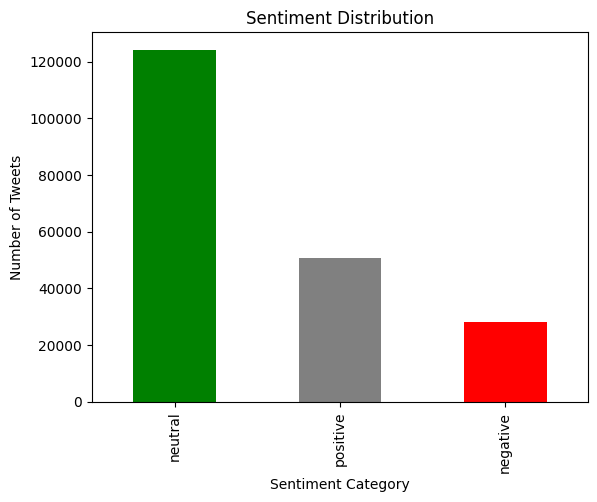

In [37]:
df["sentiment_category"] = df["sentiment"].apply(categorize_sentiment)
df["sentiment_category"].value_counts().plot(kind="bar", color=["green", "gray", "red"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.show()

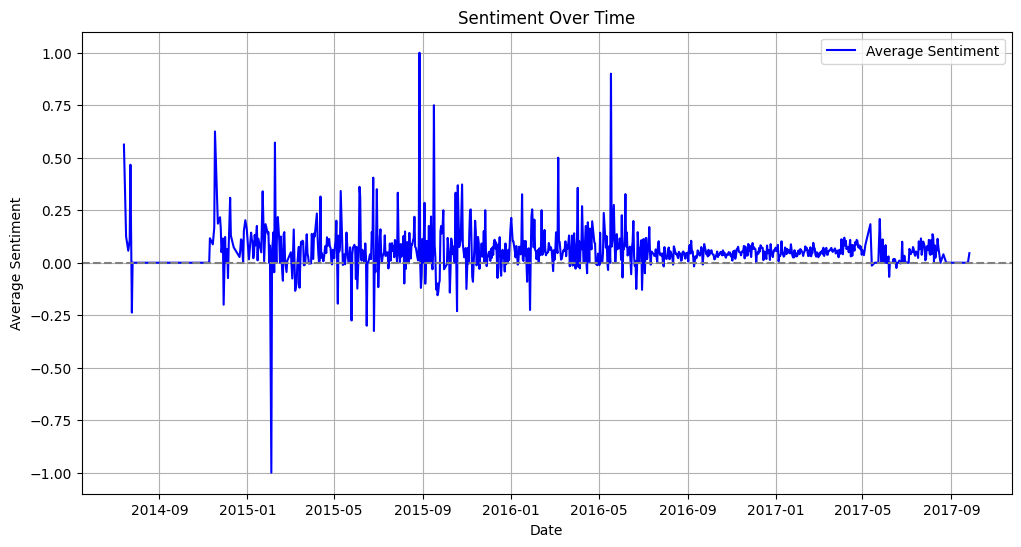

In [39]:
df["created_at"] = pd.to_datetime(df["created_at"], unit="ms")
sentiment_over_time = df.groupby(df["created_at"].dt.date)["sentiment"].mean()

plt.figure(figsize=(12, 6))
plt.plot(
    sentiment_over_time.index,
    sentiment_over_time.values,
    label="Average Sentiment",
    color="blue",
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
hashtag_sentiment = df.explode("hashtags").groupby("hashtags")["sentiment"].mean()

top_positive_hashtags = hashtag_sentiment.sort_values(ascending=False).head(10)

top_negative_hashtags = hashtag_sentiment.sort_values().head(10)

print("Top Positive Hashtags:")
print(top_positive_hashtags)
print("\nTop Negative Hashtags:")
print(top_negative_hashtags)

Top Positive Hashtags:
hashtags
SignsYouAreOnTheRightPath    1.0
rt171                        1.0
NiceTry                      1.0
artwork                      1.0
PrinceRIP                    1.0
relationships                1.0
ThoughtsBeforeBed            1.0
DeplorablesChallenge         1.0
WennFraktionskollegen        1.0
HappyTaeminDay               1.0
Name: sentiment, dtype: float64

Top Negative Hashtags:
hashtags
youreawaste      -1.0
237              -1.0
riot             -1.0
ObamaHillary     -1.0
NoneOfTheAbove   -1.0
Not1More         -1.0
DeflectLies      -1.0
FedUp            -1.0
AmberAmour       -1.0
demons           -1.0
Name: sentiment, dtype: float64


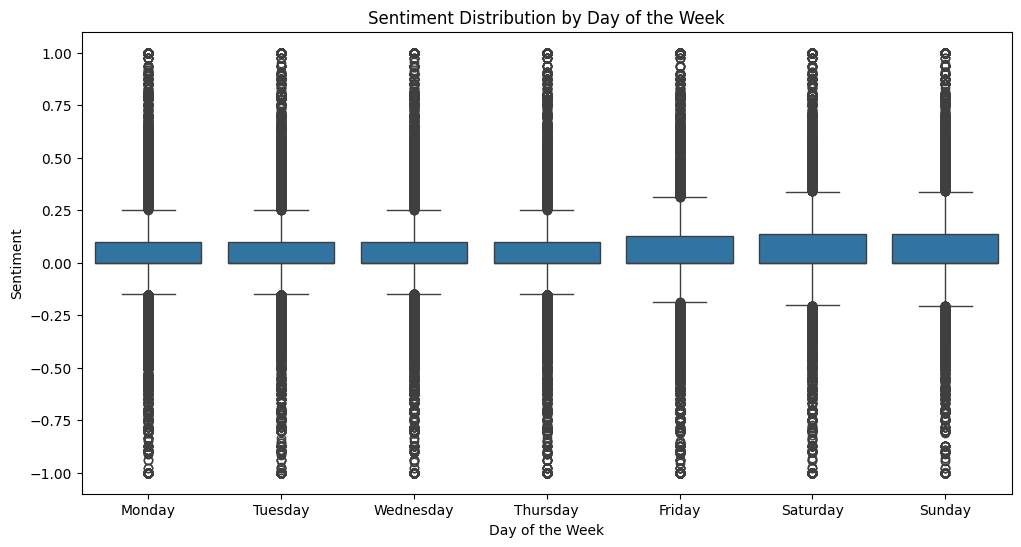

In [ ]:
df["day_of_week"] = df["created_at"].dt.day_name()

plt.figure(figsize=(12, 6))
sns.boxplot(
    x="day_of_week",
    y="sentiment",
    data=df,
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)
plt.title("Sentiment Distribution by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Sentiment")
plt.show()

### Propaganda

In [ ]:
df[["retweet_count", "favorite_count"]].corr()

In [ ]:
duplicate_tweets = df[df.duplicated(subset=["text"], keep=False)]

### Network Analysis

In [ ]:
G = nx.DiGraph()
for _, row in df.iterrows():
    if row["mentions"]:
        for mention in row["mentions"]:
            G.add_edge(row["user_key"], mention)

In [ ]:
if df is not None:
    # Create and analyze network
    G = create_interaction_network(df)
    metrics = analyze_network(G)
    patterns = analyze_tweet_patterns(df)

    # Generate visualizations
    visualize_network(G, metrics)

    # Generate report
    report = generate_report(df, metrics, patterns)

    # Save report
    with open("twitter_analysis_report.txt", "w") as f:
        f.write(report)

    print(
        "Analysis complete. Check twitter_network.png for visualization and twitter_analysis_report.txt for the report."
    )